# scAdam model optimization

Model optimization refers to the process of improving the performance and efficiency of machine learning models. <br>
scAdam models support two types of optimization: <br>

1) <strong>Warm start</strong>: Warm starting is a technique in machine learning that involves initializing a model with weights from a previously trained model on the same or a similar task. <br>
This method allows the training process to begin from a more advantageous point on the loss surface, leveraging prior knowledge to improve efficiency and performance. <br>

2) <strong>Hyperparameter tuning</strong>: This involves adjusting the hyperparameters of the model, such as learning rates, <br>
batch sizes, and other configuration settings, to optimize performance on a specific dataset.


In [1]:
import scanpy as sc
import scparadise
import os
import numpy as np
import pandas as pd
import warnings 
warnings.simplefilter('ignore')
sc.set_figure_params(dpi = 150)

/home/vadim/anaconda3/envs/scparadise/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Recommendations about training dataset 
We recommend shifted logarithm data normalization method: <br>

sc.pp.normalize_total(adata, target_sum=None) <br>
sc.pp.log1p(adata) <br>

But you can use any other method of data normalzation (Use the same normalization method for test dataset) <br>
Training dataset sould contain all genes that you want to use for model training in adata_train.X <br>
We recommend to remove all non-marker genes from adata_train.X (removeing of such useless genes may increase performance and model quality metrics and also increase training speed)

## Data preparation
Here we download and preprocess dataset from cellxgene: <br> 
Single cell RNA sequencing of oropharyngeal squamous cell carcinoma <br>
https://cellxgene.cziscience.com/collections/3c34e6f1-6827-47dd-8e19-9edcd461893f

In [2]:
!wget https://datasets.cellxgene.cziscience.com/915069db-1df2-49a1-9a9c-2fbd0aa13c81.h5ad

--2024-12-15 19:03:20--  https://datasets.cellxgene.cziscience.com/915069db-1df2-49a1-9a9c-2fbd0aa13c81.h5ad
Resolving datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)... 52.85.49.24, 52.85.49.28, 52.85.49.17, ...
Connecting to datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)|52.85.49.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 981941987 (936M) [binary/octet-stream]
Saving to: ‘915069db-1df2-49a1-9a9c-2fbd0aa13c81.h5ad’

915069db-1df2-49a1- 100%[===================>] 936.45M  7.55MB/s    in 2m 28s  

2024-12-15 19:05:48 (6.32 MB/s) - ‘915069db-1df2-49a1-9a9c-2fbd0aa13c81.h5ad’ saved [981941987/981941987]



In [2]:
# Load prepared for training anndata object
adata = sc.read_h5ad('915069db-1df2-49a1-9a9c-2fbd0aa13c81.h5ad')

In [3]:
# Get raw counts from adata.raw
adata = adata.raw.to_adata()

In [4]:
# Convert var_names from ENSG codes to gene names
adata.var.set_index('feature_name', inplace=True)
adata.var_names_make_unique()

In [5]:
# Select datasets for model training and testing
# It is necessary for all cell types to be present in both the training datasets and the testing datasets
df = scparadise.scnoah.cell_counter(adata, celltype='cell_type', sample='donor_id')
df

HN481  HN482  HN483  HN485  HN487  \
epithelial cell                        6747    758    934    575   2061   
plasma cell                             868   1051    498    609    106   
CD8-positive, alpha-beta T cell         613   1129   1204    740    279   
fibroblast                              512    164    256    163    371   
myeloid cell                            415    311    159    361    995   
regulatory T cell                       370    316    623    351    135   
endothelial cell                        283    174    144    111    122   
CD4-positive, alpha-beta T cell         282   1272   2629    911     87   
mural cell                              267    170     98    156    195   
B cell                                  213   1837   3369    764     30   
mast cell                                92     56     91     56     20   
natural killer cell                      88    135    205     65     40   
mature alpha-beta T cell                 44     31     13      7      8   
endothelial cell of lymphatic vessel     29     23     25     10      8   
plasmacytoid dendritic cell              19     31     43     25     13   

                                      HN488  HN489  HN490  HN492  HN494  
epithelial cell                        1335   2533   2955   2619    780  
plasma cell                             596   1005    975    642    579  
CD8-positive, alpha-beta T cell         941   1004    472   1408    911  
fibroblast                              118    856    204    234    560  
myeloid cell                            136    929    394    203   2998  
regulatory T cell                        69    881    385    321    616  
endothelial cell                        152    311    240    135    138  
CD4-positive, alpha-beta T cell         224   1310   1076    789   1784  
mural cell                              173    286    233     87    128  
B cell                                 2053   1338   2297    942   1832  
mast cell                                39     33     29     74     27  
natural killer cell                     120    465     94     58    128  
mature alpha-beta T cell                  7     82     30     38     42  
endothelial cell of lymphatic vessel      9     59      6     28      8  
plasmacytoid dendritic cell              22     87     24     20    163

In [18]:
# Create adata_train1, adata_train2 and adata_test datasets
adata_test = adata[adata.obs['donor_id'].isin(['HN481', 'HN482'])].copy()
adata_train1 = adata[adata.obs['donor_id'].isin(['HN483' 'HN485', 'HN488', 'HN489'])].copy()
adata_train2 = adata[adata.obs['donor_id'].isin(['HN490', 'HN487', 'HN492', 'HN494'])].copy()
#del adata

In [19]:
# Normalize data, find highly variable features
for i in [adata_train1, adata_train2, adata_test]:
    i.layers['counts'] = i.X.copy()
    sc.pp.normalize_total(i, target_sum=None)
    sc.pp.log1p(i)
    i.raw = i
    sc.pp.highly_variable_genes(i,
                                layer='counts',
                                flavor='seurat_v3',
                                n_top_genes=1200,
                                subset=True)

## Default model training
Use 'balanced_accuracy' as the evaluation metric in this case due to the imbalance in the number of cells among cell types.

In [29]:
# Train scadam model using adata_train1 dataset
scparadise.scadam.train(adata_train1,
                        path='', # path to save model
                        model_name='model_scadam', # folder name with model
                        celltype_l1='cell_type',
                        eval_metric=['accuracy','balanced_accuracy']) # If you are using an imbalanced training dataset, we recommend using balanced_accuracy for early stopping

Successfully saved genes names for training model

Successfully saved dictionary of dataset annotations

Train dataset contains: 15455 cells, it is 90.0 % of input dataset
Test dataset contains: 1718 cells, it is 10.0 % of input dataset

Accelerator: cuda
Start training
epoch 0  | loss: 2.55518 | train_accuracy: 0.34455 | train_balanced_accuracy: 0.1102  | valid_accuracy: 0.34517 | valid_balanced_accuracy: 0.11042 |  0:00:00s
epoch 1  | loss: 2.00387 | train_accuracy: 0.42077 | train_balanced_accuracy: 0.13547 | valid_accuracy: 0.41909 | valid_balanced_accuracy: 0.13511 |  0:00:01s
epoch 2  | loss: 1.65271 | train_accuracy: 0.58932 | train_balanced_accuracy: 0.29457 | valid_accuracy: 0.57625 | valid_balanced_accuracy: 0.28318 |  0:00:02s
epoch 3  | loss: 1.28917 | train_accuracy: 0.60679 | train_balanced_accuracy: 0.31877 | valid_accuracy: 0.60419 | valid_balanced_accuracy: 0.31184 |  0:00:03s
epoch 4  | loss: 1.09993 | train_accuracy: 0.68515 | train_balanced_accuracy: 0.41748 | valid

In [30]:
# Predict cell types using trained model
adata_test = scparadise.scadam.predict(adata_test, 
                                       path_model = 'model_scadam')

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities


### Evaluation of prediction quality
Model cant predict 'mature alpha-beta T cell' (sensitivity = 0.0667). <br>
There is also low sensitivity to 'endothelial cell of lymphatic vessel' and 'regulatory T cell'.

In [31]:
## Check model quality
df = scparadise.scnoah.report_classif_full(adata_test,
                                           celltype='cell_type',
                                           pred_celltype='pred_celltype_l1')
df

precision recall/sensitivity  \
B cell                                   0.8170               0.98   
CD4-positive, alpha-beta T cell          0.5112             0.8481   
CD8-positive, alpha-beta T cell          0.6327             0.8829   
endothelial cell                         0.7873             0.9803   
endothelial cell of lymphatic vessel     0.8475             0.9615   
epithelial cell                          0.9907             0.4994   
fibroblast                               0.9379             0.8935   
mast cell                                0.9797             0.9797   
mature alpha-beta T cell                 0.0665               0.84   
mural cell                               0.8173             0.9519   
myeloid cell                             0.8784             0.9449   
natural killer cell                      0.5929             0.9731   
plasma cell                              0.9810             0.9937   
plasmacytoid dendritic cell              0.9231               0.96   
regulatory T cell                        0.4762             0.7143   
macro avg                                0.7493             0.8936   
weighted avg                             0.8512             0.7479   
Accuracy                                 0.7479                      
Balanced accuracy                        0.8936                      

                                     specificity f1-score geometric mean  \
B cell                                    0.9723   0.8911         0.9761   
CD4-positive, alpha-beta T cell           0.9248   0.6379         0.8856   
CD8-positive, alpha-beta T cell           0.9461   0.7371         0.9139   
endothelial cell                          0.9932   0.8733         0.9867   
endothelial cell of lymphatic vessel      0.9995   0.9009         0.9803   
epithelial cell                           0.9968   0.6641         0.7055   
fibroblast                                0.9977   0.9152         0.9442   
mast cell                                 0.9998   0.9797         0.9897   
mature alpha-beta T cell                  0.9514   0.1232          0.894   
mural cell                                0.9948   0.8795         0.9731   
myeloid cell                              0.9946   0.9104         0.9694   
natural killer cell                       0.9918   0.7368         0.9824   
plasma cell                               0.9977   0.9873         0.9957   
plasmacytoid dendritic cell               0.9998   0.9412         0.9797   
regulatory T cell                         0.9694   0.5714         0.8321   
macro avg                                  0.982   0.7833         0.9339   
weighted avg                              0.9818   0.7567         0.8468   
Accuracy                                                                   
Balanced accuracy                                                          

                                     index balanced accuracy number of cells  
B cell                                                0.9536            2050  
CD4-positive, alpha-beta T cell                       0.7783            1554  
CD8-positive, alpha-beta T cell                         0.83            1742  
endothelial cell                                      0.9724             457  
endothelial cell of lymphatic vessel                  0.9574              52  
epithelial cell                                        0.473            7505  
fibroblast                                            0.8822             676  
mast cell                                             0.9776             148  
mature alpha-beta T cell                              0.7903              75  
mural cell                                            0.9429             437  
myeloid cell                                          0.9351             726  
natural killer cell                                   0.9633             223  
plasma cell                                           0.9911            1919  
plasmacyto

In [32]:
# Order cell type colors
celltype = np.unique(adata_test.obs['cell_type']).tolist()
adata_test.obs['cell_type'] = pd.Categorical(
    values=adata_test.obs['cell_type'], categories=celltype, ordered=True
)
adata_test.obs['pred_celltype_l1'] = pd.Categorical(
    values=adata_test.obs['pred_celltype_l1'], categories=celltype, ordered=True
)
adata_test = scparadise.scnoah.pred_status(adata_test, celltype='cell_type', pred_celltype='pred_celltype_l1')

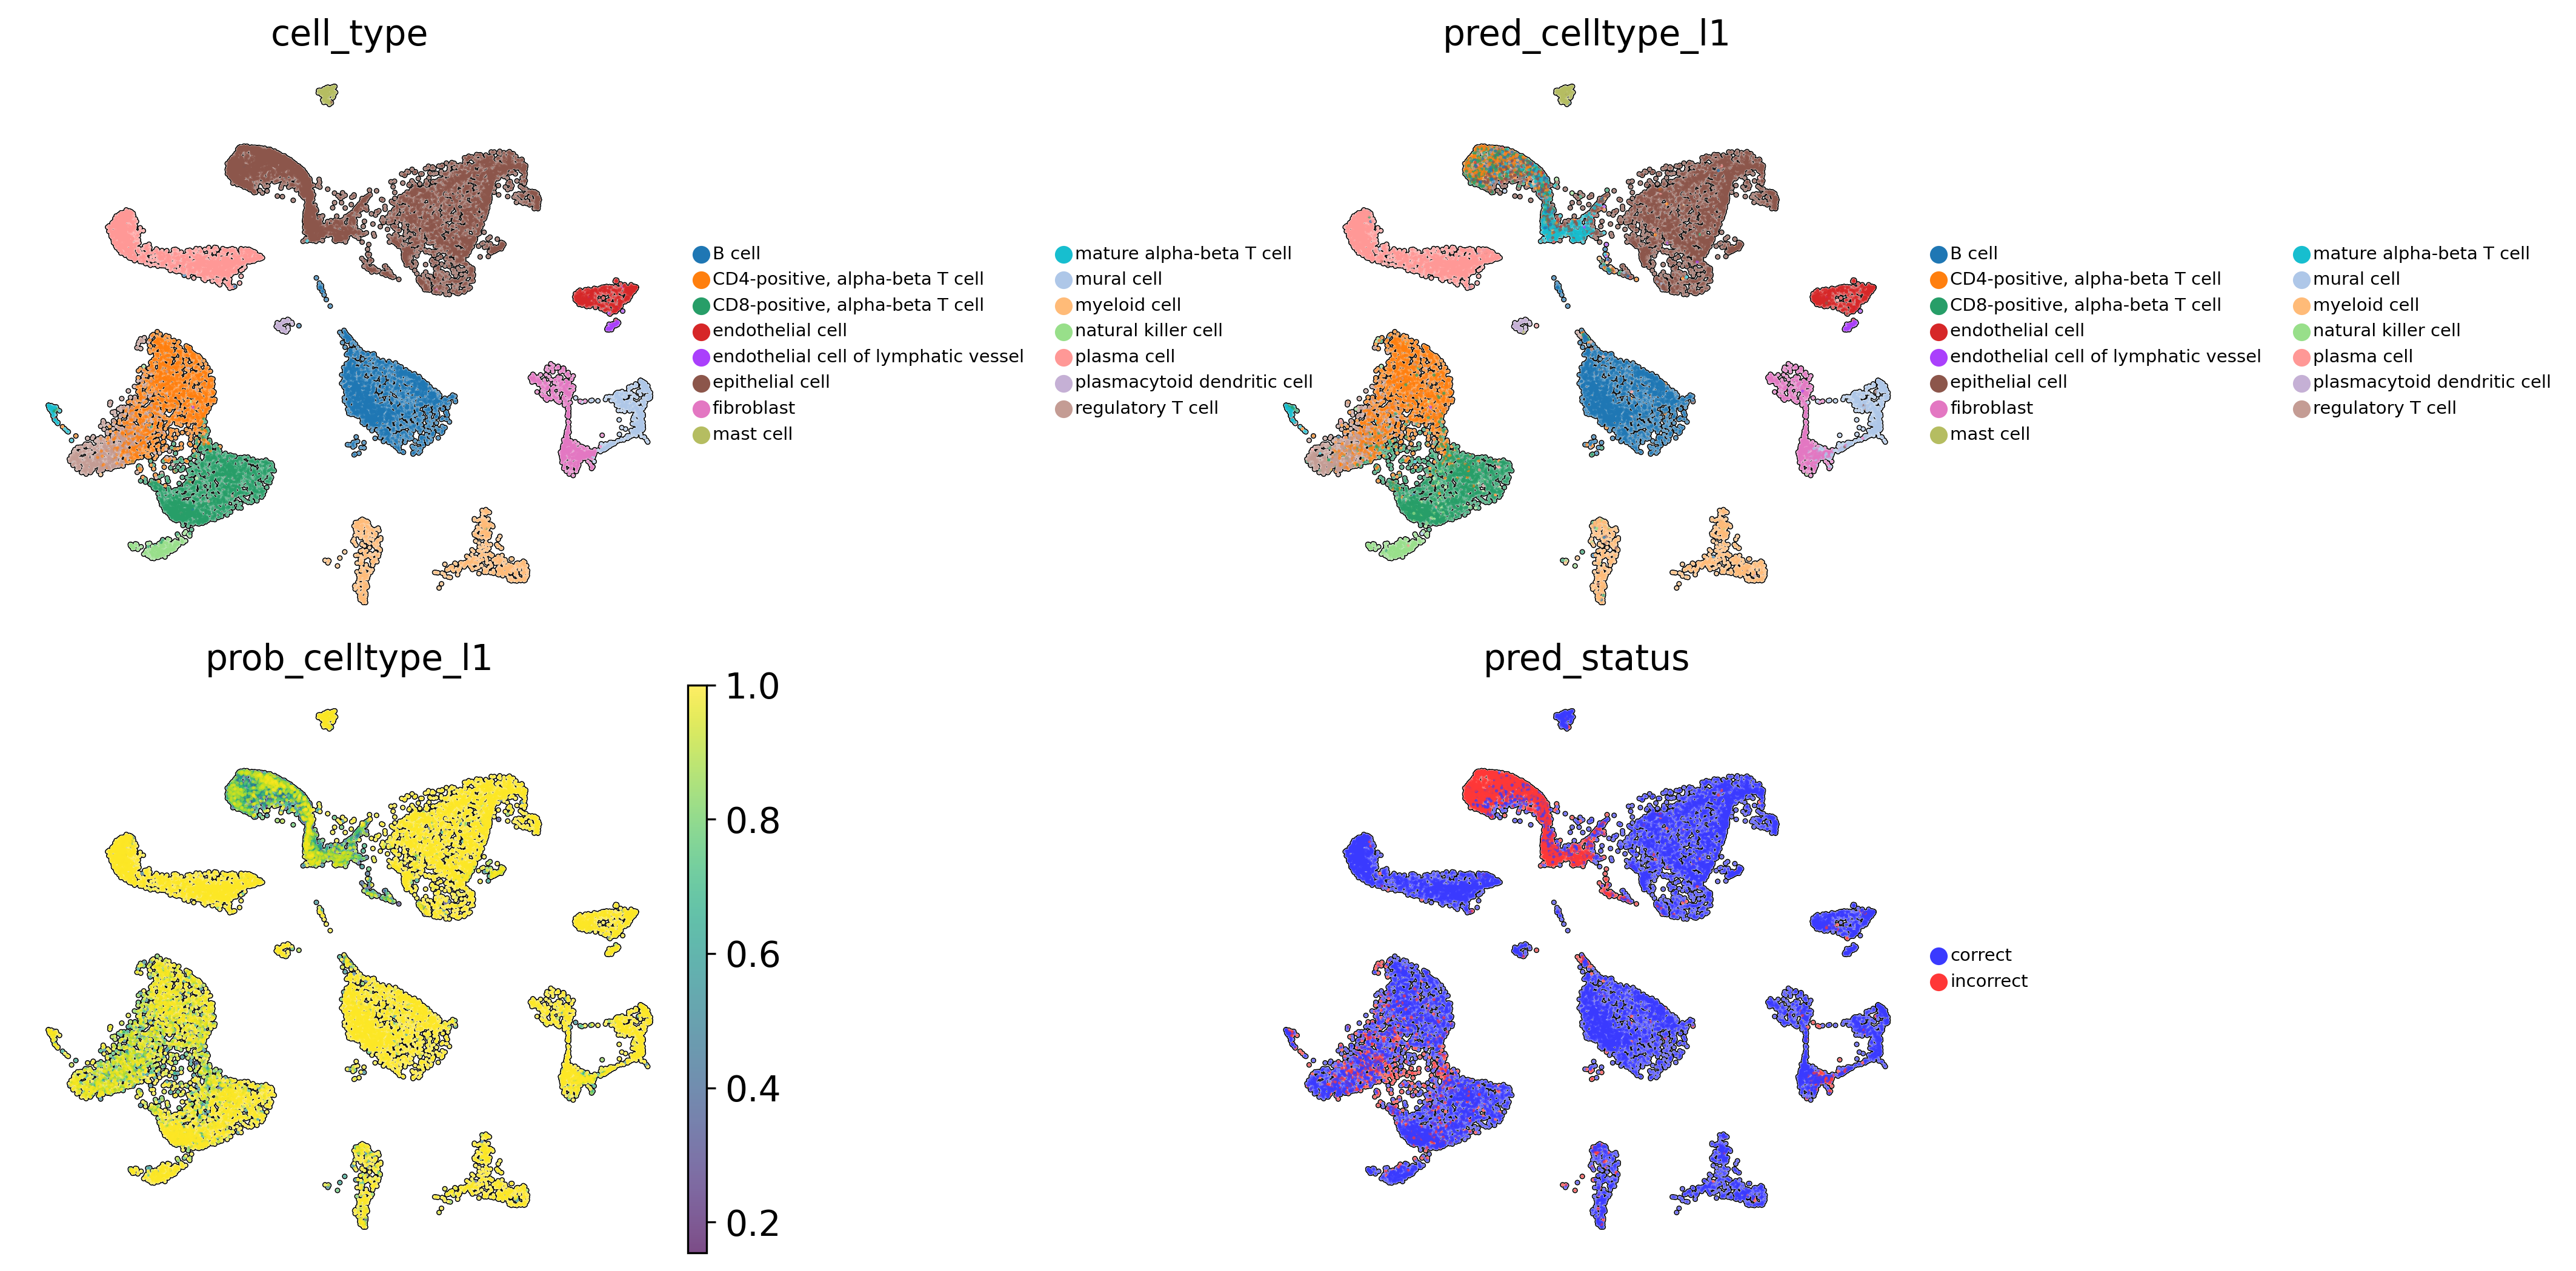

In [33]:
# Visualise predicted cell types levels, prediction probabilities and prediction status
sc.pl.embedding(adata_test, 
                color=[
                    'cell_type',
                    'pred_celltype_l1',
                    'prob_celltype_l1',
                    'pred_status'
                ],
                basis = 'X_umap',
                frameon = False,
                add_outline = True,
                legend_loc = 'right margin',
                legend_fontsize = 7,
                legend_fontoutline = 1,
                ncols=2,
                wspace = 0.7, 
                hspace = 0.1)

## Warm start model training
<strong>WARNING!</strong> <br>
For warm start scAdam model training, a dataset is required that contains all the same cell types that were present in the original training. <br>
The cell types must be named exactly as they were during the initial training of the model. <br>
1) There should be no new additional cell types or levels of annotation. 
2) Additionally, none of the cell types used for the initial training of the model should be missing.

In [34]:
# Warm start requires second training dataset and path to pretrained model 
scparadise.scadam.warm_start(adata_train2,
                             path='', # path to save model
                             model_name='model_scadam', # folder name with pretrained model
                             celltype_l1='cell_type',
                             eval_metric=['accuracy','balanced_accuracy']) # If you are using an imbalanced training dataset, we recommend using balanced_accuracy for early stopping

Successfully loaded list of genes used for training model

Train dataset contains: 28958 cells, it is 90.0 % of input dataset
Test dataset contains: 3218 cells, it is 10.0 % of input dataset


Successfully loaded parameters
Accelerator: cuda
Start training
epoch 0  | loss: 0.39464 | train_accuracy: 0.95114 | train_balanced_accuracy: 0.9084  | valid_accuracy: 0.95059 | valid_balanced_accuracy: 0.91401 |  0:00:01s
epoch 1  | loss: 0.31958 | train_accuracy: 0.95701 | train_balanced_accuracy: 0.94684 | valid_accuracy: 0.95401 | valid_balanced_accuracy: 0.94443 |  0:00:03s
epoch 2  | loss: 0.30485 | train_accuracy: 0.95849 | train_balanced_accuracy: 0.95216 | valid_accuracy: 0.94624 | valid_balanced_accuracy: 0.9447  |  0:00:04s
epoch 3  | loss: 0.29525 | train_accuracy: 0.96074 | train_balanced_accuracy: 0.94526 | valid_accuracy: 0.94779 | valid_balanced_accuracy: 0.93132 |  0:00:06s
epoch 4  | loss: 0.27713 | train_accuracy: 0.96564 | train_balanced_accuracy: 0.95579 | valid_accuracy: 0.9

In [35]:
# Predict cell types using trained model
adata_test = scparadise.scadam.predict(adata_test, 
                                       path_model = 'model_scadam')

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities


### Evaluation of prediction results
Warm start leads to an increase in the model's accuracy, balanced accuracy and precision. <br>
Below are examples of improved model performance for certain cell types. <br>
1) mature alpha-beta T cell (precision - 0.6036 vs 0.0665)
2) regulatory T cell (precision - 0.7766 vs 0.4762)
3) natural killer cell (precision - 0.8991 vs 0.5929)
4) fibroblast (sensitivity - 0.9896 vs 0.8935)
5) epithelial cell (sensitivity - 0.9824 vs 0.4994)

In [36]:
## Check model quality
df_warm_start = scparadise.scnoah.report_classif_full(adata_test,
                                                      celltype='cell_type',
                                                      pred_celltype='pred_celltype_l1')
df_warm_start

precision recall/sensitivity  \
B cell                                   0.9738              0.978   
CD4-positive, alpha-beta T cell          0.8644             0.8411   
CD8-positive, alpha-beta T cell          0.8985             0.9248   
endothelial cell                         0.9868             0.9803   
endothelial cell of lymphatic vessel     0.9592             0.9038   
epithelial cell                          0.9879             0.9824   
fibroblast                               0.9585             0.9896   
mast cell                                0.9931              0.973   
mature alpha-beta T cell                 0.6036             0.8933   
mural cell                               0.9761             0.9336   
myeloid cell                             0.9832             0.9656   
natural killer cell                      0.8991             0.9193   
plasma cell                              0.9830             0.9917   
plasmacytoid dendritic cell              0.9074               0.98   
regulatory T cell                        0.7766             0.7551   
macro avg                                0.9167             0.9341   
weighted avg                             0.9544             0.9538   
Accuracy                                 0.9538                      
Balanced accuracy                        0.9341                      

                                     specificity f1-score geometric mean  \
B cell                                    0.9967   0.9759         0.9873   
CD4-positive, alpha-beta T cell           0.9878   0.8526         0.9115   
CD8-positive, alpha-beta T cell            0.989   0.9115         0.9564   
endothelial cell                          0.9997   0.9835         0.9899   
endothelial cell of lymphatic vessel      0.9999   0.9307         0.9507   
epithelial cell                           0.9917   0.9852          0.987   
fibroblast                                0.9984   0.9738          0.994   
mast cell                                 0.9999   0.9829         0.9864   
mature alpha-beta T cell                  0.9976   0.7204          0.944   
mural cell                                0.9994   0.9544          0.966   
myeloid cell                              0.9993   0.9743         0.9823   
natural killer cell                       0.9987   0.9091         0.9582   
plasma cell                                0.998   0.9873         0.9948   
plasmacytoid dendritic cell               0.9997   0.9423         0.9898   
regulatory T cell                         0.9915   0.7657         0.8653   
macro avg                                 0.9965   0.9233         0.9642   
weighted avg                              0.9935   0.9539          0.973   
Accuracy                                                                   
Balanced accuracy                                                          

                                     index balanced accuracy number of cells  
B cell                                                 0.973            2050  
CD4-positive, alpha-beta T cell                       0.8186            1554  
CD8-positive, alpha-beta T cell                       0.9088            1742  
endothelial cell                                      0.9781             457  
endothelial cell of lymphatic vessel                  0.8951              52  
epithelial cell                                       0.9733            7505  
fibroblast                                            0.9872             676  
mast cell                                             0.9703             148  
mature alpha-beta T cell                              0.8819              75  
mural cell                                             0.927             437  
myeloid cell                                          0.9616             726  
natural killer cell                                   0.9108             223  
plasma cell                                            0.989            1919  
plasmacyto

In [37]:
# Order cell type colors
celltype = np.unique(adata_test.obs['cell_type']).tolist()
adata_test.obs['cell_type'] = pd.Categorical(
    values=adata_test.obs['cell_type'], categories=celltype, ordered=True
)
adata_test.obs['pred_celltype_l1'] = pd.Categorical(
    values=adata_test.obs['pred_celltype_l1'], categories=celltype, ordered=True
)
# Add prediction status. Label cells as correct or incorrect based on the comparison between ground truth cell types and predictions.
adata_test = scparadise.scnoah.pred_status(adata_test, celltype='cell_type', pred_celltype='pred_celltype_l1')

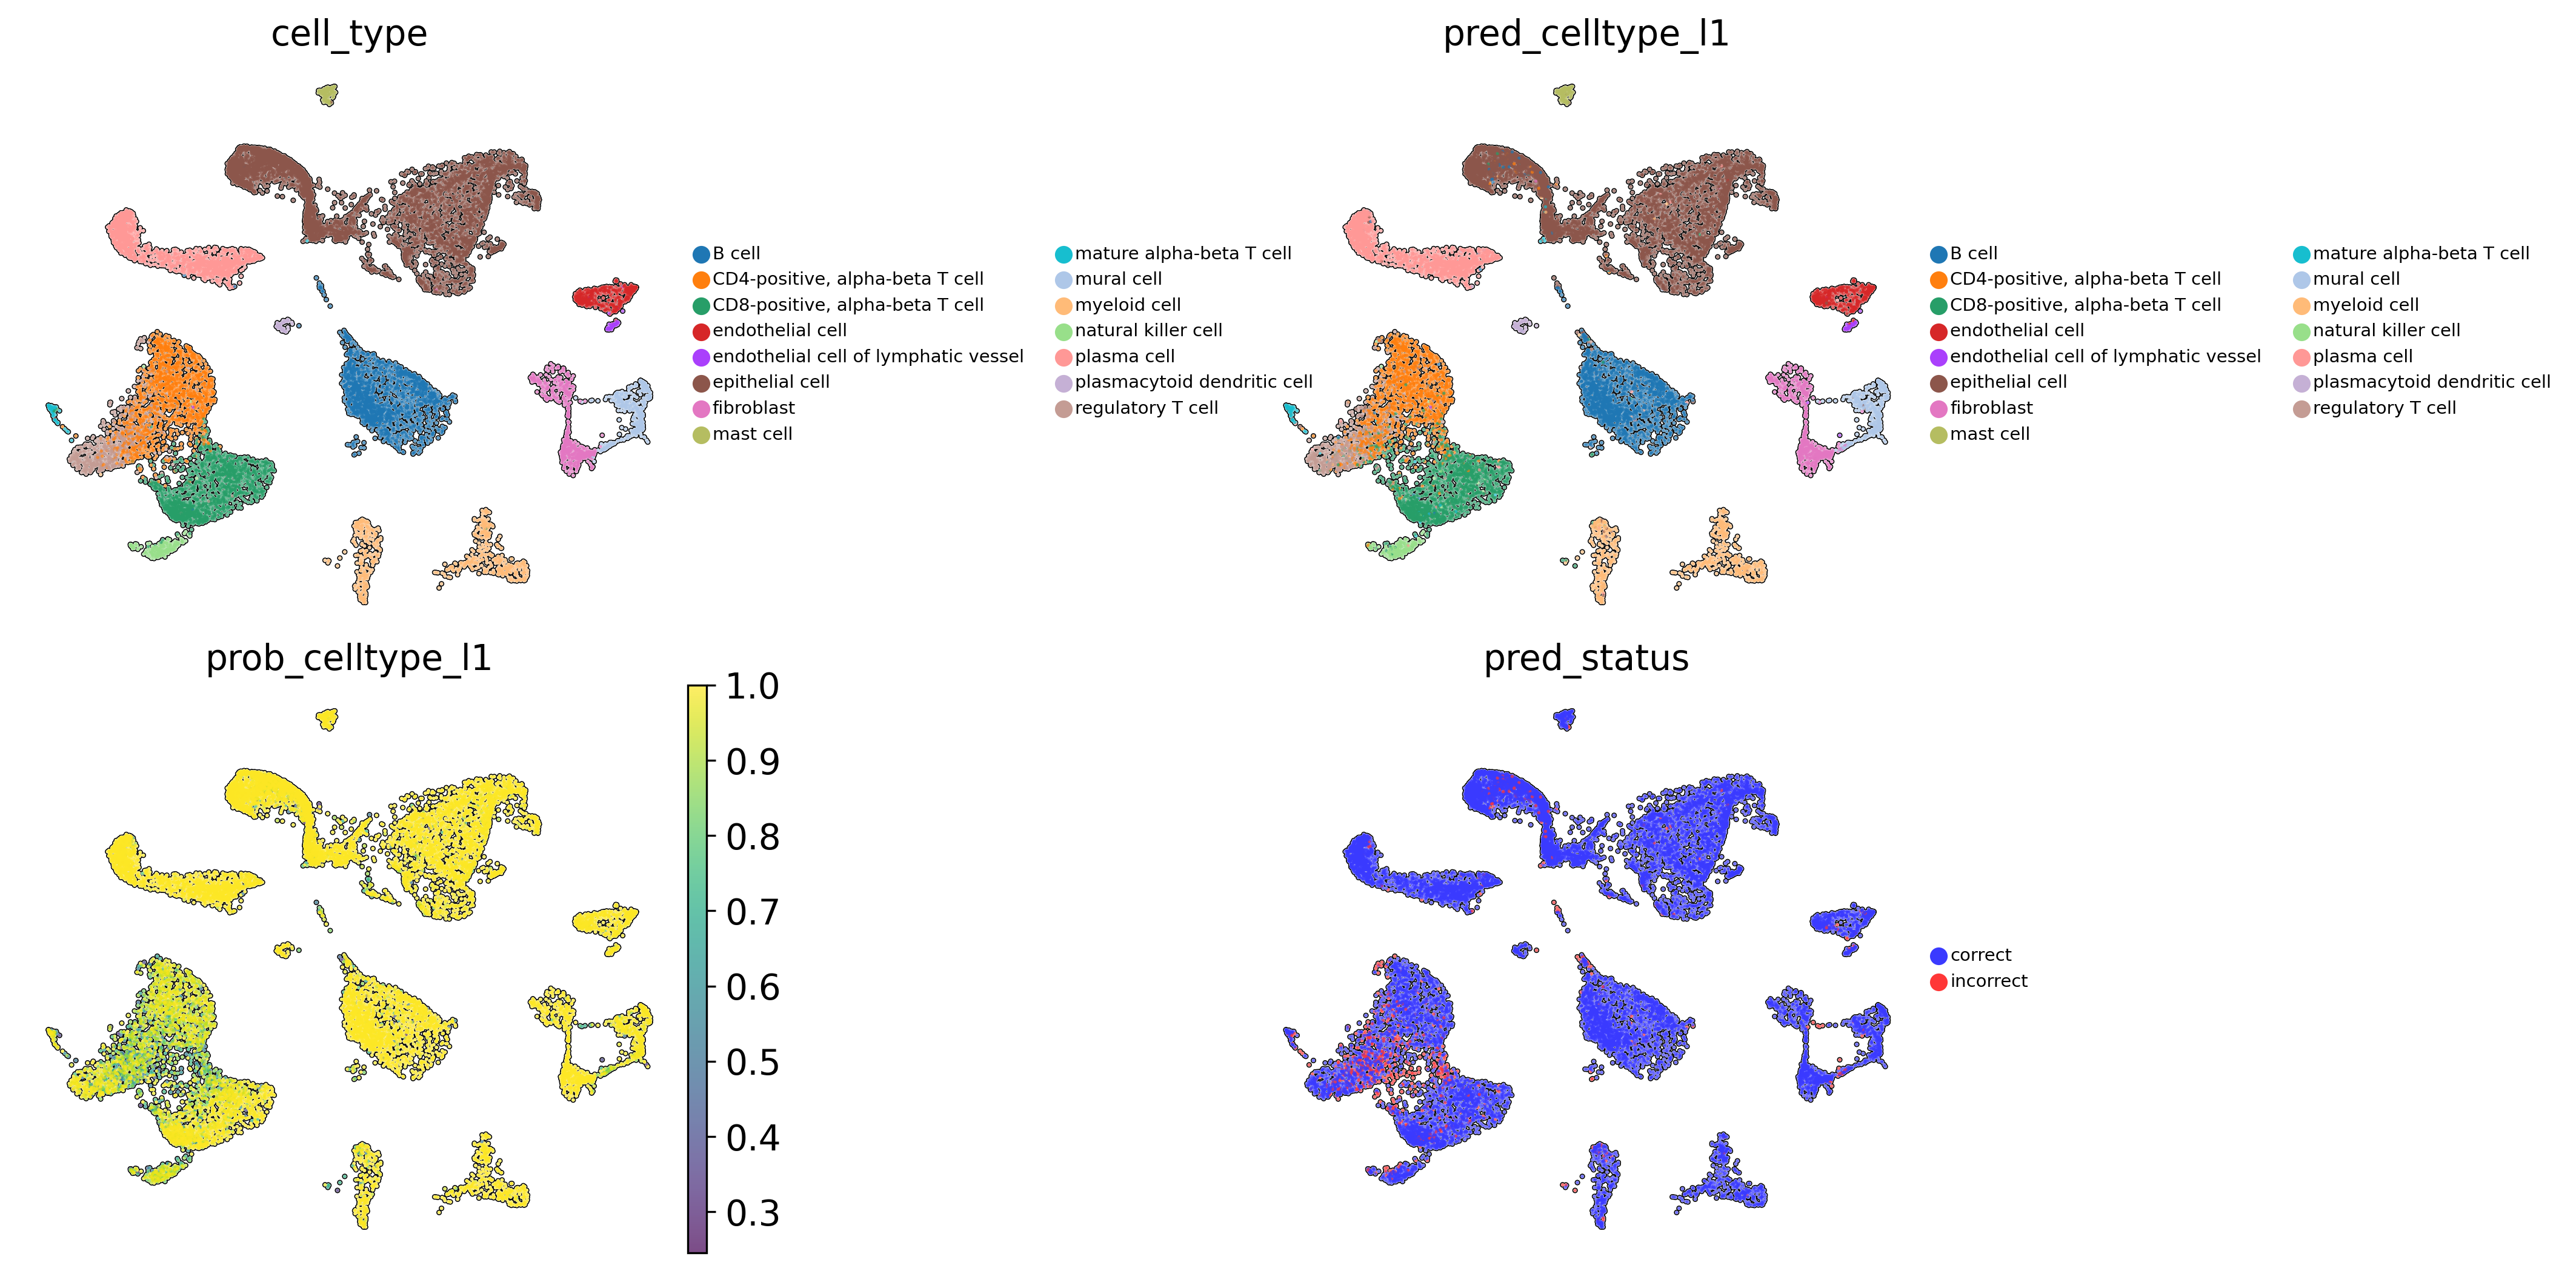

In [38]:
# Visualise predicted cell types levels, prediction probabilities and prediction status
sc.pl.embedding(adata_test, 
                color=[
                    'cell_type',
                    'pred_celltype_l1',
                    'prob_celltype_l1',
                    'pred_status'
                ],
                basis = 'X_umap',
                frameon = False,
                add_outline = True,
                legend_loc = 'right margin',
                legend_fontsize = 7,
                legend_fontoutline = 1,
                ncols=2,
                wspace = 0.7, 
                hspace = 0.1)

In [39]:
# Compare prediction results
# 'self' row represents untuned model
# 'other' row represents warm start model
df.compare(df_warm_start, keep_equal=True, align_axis = 0, result_names=('untuned', 'warm start'))

precision recall/sensitivity  \
B cell                               self      0.8170               0.98   
                                     other     0.9738              0.978   
CD4-positive, alpha-beta T cell      self      0.5112             0.8481   
                                     other     0.8644             0.8411   
CD8-positive, alpha-beta T cell      self      0.6327             0.8829   
                                     other     0.8985             0.9248   
endothelial cell                     self      0.7873             0.9803   
                                     other     0.9868             0.9803   
endothelial cell of lymphatic vessel self      0.8475             0.9615   
                                     other     0.9592             0.9038   
epithelial cell                      self      0.9907             0.4994   
                                     other     0.9879             0.9824   
fibroblast                           self      0.9379             0.8935   
                                     other     0.9585             0.9896   
mast cell                            self      0.9797             0.9797   
                                     other     0.9931              0.973   
mature alpha-beta T cell             self      0.0665               0.84   
                                     other     0.6036             0.8933   
mural cell                           self      0.8173             0.9519   
                                     other     0.9761             0.9336   
myeloid cell                         self      0.8784             0.9449   
                                     other     0.9832             0.9656   
natural killer cell                  self      0.5929             0.9731   
                                     other     0.8991             0.9193   
plasma cell                          self      0.9810             0.9937   
                                     other     0.9830             0.9917   
plasmacytoid dendritic cell          self      0.9231               0.96   
                                     other     0.9074               0.98   
regulatory T cell                    self      0.4762             0.7143   
                                     other     0.7766             0.7551   
macro avg                            self      0.7493             0.8936   
                                     other     0.9167             0.9341   
weighted avg                         self      0.8512             0.7479   
                                     other     0.9544             0.9538   
Accuracy                             self      0.7479                      
                                     other     0.9538                      
Balanced accuracy                    self      0.8936                      
                                     other     0.9341                      

                                           specificity f1-score  \
B cell                               self       0.9723   0.8911   
                                     other      0.9967   0.9759   
CD4-positive, alpha-beta T cell      self       0.9248   0.6379   
                                     other      0.9878   0.8526   
CD8-positive, alpha-beta T cell      self       0.9461   0.7371   
                                     other       0.989   0.9115   
endothelial cell                     self       0.9932   0.8733   
                                     other      0.9997   0.9835   
endothelial cell of lymphatic vessel self       0.9995   0.9009   
                                     other      0.9999   0.9307   
epithelial cell                      self       0.9968   0.6641   
                                     other      0.9917   0.9852   
fibroblast                           self       0.9977   0.9152   
                                     other      0.9984   0.9738   
mast cell                            self       0.9998   0.9797   
       

## Hyperparameters tuning
Hyperparameters are specific configurations that govern the learning process but are not learned from the training data. <br> 
Examples include learning rates, batch sizes, patience, etc. <br> 
In scAdam and scEve models, you can tune up to 15 hyperparameters simultaneously using optuna algorithm. <br>

<strong>Warning!</strong> <br> 
Hyperparameter tuning is a very time-consuming process and may be interrupted for various reasons (such as system shutdowns or errors in CUDA). <br> 
However, this is not a problem, as restarting the hyperparameter tuning will allow it to continue from the last unfinished trial. <br>

An example of hyperparameter tuning represents such a case. <br>
The fourth line states: "Using an existing study with name 'model_scadam_hp_tune' instead of creating a new one." <br>
This indicates a restart of hyperparameter tuning (in this case, from the 8th trial).

In [20]:
scparadise.scadam.hyperparameter_tuning(adata_train1,
                                        path='',
                                        model_name='model_scadam_hp_tune', # Folder to save hyperparameter tuning results
                                        celltype_l1='cell_type',
                                        num_trials=50, # The number of attempts to find the optimal hyperparameters for the model (recommended - minimum 100)
                                        eval_metric=['accuracy','balanced_accuracy'])

Successfully saved genes names for training model

Successfully saved dictionary of dataset annotations

Accelerator: cuda



[I 2024-12-17 16:56:48,662] Using an existing study with name 'model_scadam_hp_tune' instead of creating a new one.


Fold 1:

Early stopping occurred at epoch 19 with best_epoch = 4 and best_valid_balanced_accuracy = 0.12159


[I 2024-12-17 16:57:06,116] Trial 8 pruned. 


Fold 1:
Stop training because you reached max_epochs = 50 with best_epoch = 42 and best_valid_balanced_accuracy = 0.30773


[I 2024-12-17 16:57:48,788] Trial 9 pruned. 


Fold 1:
Stop training because you reached max_epochs = 45 with best_epoch = 40 and best_valid_balanced_accuracy = 0.95197

Fold 2:
Stop training because you reached max_epochs = 45 with best_epoch = 32 and best_valid_balanced_accuracy = 0.95653

Fold 3:
Stop training because you reached max_epochs = 45 with best_epoch = 33 and best_valid_balanced_accuracy = 0.95143

Fold 4:
Stop training because you reached max_epochs = 45 with best_epoch = 30 and best_valid_balanced_accuracy = 0.95292


[I 2024-12-17 17:00:38,489] Trial 10 finished with value: 0.9532140393068294 and parameters: {'n_d': 124, 'n_a': 92, 'n_steps': 4, 'n_shared': 5, 'cat_emb_dim': 7, 'n_independent': 1, 'gamma': 1.6667667154456676, 'momentum': 0.27154876915108217, 'lr': 0.10527024228081307, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0009586155312153562, 'patience': 15, 'max_epochs': 45, 'virtual_batch_size': 128, 'batch_size': 896}. Best is trial 10 with value: 0.9532140393068294.



Fold 1:

Early stopping occurred at epoch 9 with best_epoch = 4 and best_valid_balanced_accuracy = 0.09804


[I 2024-12-17 17:01:06,583] Trial 11 pruned. 


Fold 1:

Early stopping occurred at epoch 12 with best_epoch = 2 and best_valid_balanced_accuracy = 0.10296


[I 2024-12-17 17:01:21,539] Trial 12 pruned. 


Fold 1:

Early stopping occurred at epoch 35 with best_epoch = 25 and best_valid_balanced_accuracy = 0.94294

Fold 2:

Early stopping occurred at epoch 43 with best_epoch = 33 and best_valid_balanced_accuracy = 0.95294

Fold 3:

Early stopping occurred at epoch 40 with best_epoch = 30 and best_valid_balanced_accuracy = 0.94829

Fold 4:

Early stopping occurred at epoch 38 with best_epoch = 28 and best_valid_balanced_accuracy = 0.95632


[I 2024-12-17 17:03:00,448] Trial 13 finished with value: 0.9501192387079038 and parameters: {'n_d': 48, 'n_a': 44, 'n_steps': 1, 'n_shared': 3, 'cat_emb_dim': 7, 'n_independent': 3, 'gamma': 1.3155465245255713, 'momentum': 0.015628332308846832, 'lr': 0.022300516115261078, 'mask_type': 'entmax', 'lambda_sparse': 0.001323640069167409, 'patience': 10, 'max_epochs': 75, 'virtual_batch_size': 128, 'batch_size': 768}. Best is trial 10 with value: 0.9532140393068294.



Fold 1:

Early stopping occurred at epoch 22 with best_epoch = 12 and best_valid_balanced_accuracy = 0.9479

Fold 2:

Early stopping occurred at epoch 23 with best_epoch = 13 and best_valid_balanced_accuracy = 0.9517

Fold 3:

Early stopping occurred at epoch 30 with best_epoch = 20 and best_valid_balanced_accuracy = 0.95081


[I 2024-12-17 17:04:23,766] Trial 14 pruned. 


Fold 1:

Early stopping occurred at epoch 42 with best_epoch = 32 and best_valid_balanced_accuracy = 0.94818

Fold 2:

Early stopping occurred at epoch 40 with best_epoch = 30 and best_valid_balanced_accuracy = 0.95425

Fold 3:

Early stopping occurred at epoch 28 with best_epoch = 18 and best_valid_balanced_accuracy = 0.9401


[I 2024-12-17 17:05:54,421] Trial 15 pruned. 


Fold 1:

Early stopping occurred at epoch 20 with best_epoch = 15 and best_valid_balanced_accuracy = 0.75417


[I 2024-12-17 17:06:21,883] Trial 16 pruned. 


Fold 1:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_balanced_accuracy = 0.9491

Fold 2:
Stop training because you reached max_epochs = 65 with best_epoch = 51 and best_valid_balanced_accuracy = 0.95384

Fold 3:
Stop training because you reached max_epochs = 65 with best_epoch = 49 and best_valid_balanced_accuracy = 0.95196

Fold 4:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_balanced_accuracy = 0.95086


[I 2024-12-17 17:09:16,394] Trial 17 finished with value: 0.9514360808085562 and parameters: {'n_d': 84, 'n_a': 112, 'n_steps': 2, 'n_shared': 7, 'cat_emb_dim': 6, 'n_independent': 1, 'gamma': 1.5030605109294553, 'momentum': 0.20760649764410705, 'lr': 0.05660643128255937, 'mask_type': 'entmax', 'lambda_sparse': 0.008471890017944976, 'patience': 20, 'max_epochs': 65, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 10 with value: 0.9532140393068294.



Fold 1:
Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_valid_balanced_accuracy = 0.88263

Fold 2:
Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_valid_balanced_accuracy = 0.92126

Fold 3:
Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_valid_balanced_accuracy = 0.88974


[I 2024-12-17 17:10:09,304] Trial 18 pruned. 


Fold 1:
Stop training because you reached max_epochs = 60 with best_epoch = 51 and best_valid_balanced_accuracy = 0.94394

Fold 2:
Stop training because you reached max_epochs = 60 with best_epoch = 42 and best_valid_balanced_accuracy = 0.94609

Fold 3:
Stop training because you reached max_epochs = 60 with best_epoch = 59 and best_valid_balanced_accuracy = 0.94985


[I 2024-12-17 17:12:35,400] Trial 19 pruned. 


Fold 1:
Stop training because you reached max_epochs = 15 with best_epoch = 12 and best_valid_balanced_accuracy = 0.25899


[I 2024-12-17 17:12:56,643] Trial 20 pruned. 


Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 63 and best_valid_balanced_accuracy = 0.95048

Fold 2:
Stop training because you reached max_epochs = 80 with best_epoch = 73 and best_valid_balanced_accuracy = 0.95068

Fold 3:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_balanced_accuracy = 0.95031


[I 2024-12-17 17:18:31,330] Trial 21 pruned. 


Fold 1:

Early stopping occurred at epoch 30 with best_epoch = 20 and best_valid_balanced_accuracy = 0.94582

Fold 2:

Early stopping occurred at epoch 36 with best_epoch = 26 and best_valid_balanced_accuracy = 0.95586

Fold 3:

Early stopping occurred at epoch 35 with best_epoch = 25 and best_valid_balanced_accuracy = 0.94643


[I 2024-12-17 17:19:54,289] Trial 22 pruned. 


Fold 1:
Stop training because you reached max_epochs = 40 with best_epoch = 35 and best_valid_balanced_accuracy = 0.9449

Fold 2:
Stop training because you reached max_epochs = 40 with best_epoch = 30 and best_valid_balanced_accuracy = 0.95382

Fold 3:
Stop training because you reached max_epochs = 40 with best_epoch = 26 and best_valid_balanced_accuracy = 0.95427

Fold 4:
Stop training because you reached max_epochs = 40 with best_epoch = 38 and best_valid_balanced_accuracy = 0.95487


[I 2024-12-17 17:21:47,902] Trial 23 finished with value: 0.9519649530929056 and parameters: {'n_d': 28, 'n_a': 104, 'n_steps': 2, 'n_shared': 4, 'cat_emb_dim': 6, 'n_independent': 1, 'gamma': 1.178399586222898, 'momentum': 0.11624408126387431, 'lr': 0.05461797882680373, 'mask_type': 'entmax', 'lambda_sparse': 0.004533711957980013, 'patience': 15, 'max_epochs': 40, 'virtual_batch_size': 128, 'batch_size': 768}. Best is trial 10 with value: 0.9532140393068294.



Fold 1:
Stop training because you reached max_epochs = 40 with best_epoch = 30 and best_valid_balanced_accuracy = 0.95087

Fold 2:
Stop training because you reached max_epochs = 40 with best_epoch = 32 and best_valid_balanced_accuracy = 0.95126

Fold 3:
Stop training because you reached max_epochs = 40 with best_epoch = 27 and best_valid_balanced_accuracy = 0.95497

Fold 4:
Stop training because you reached max_epochs = 40 with best_epoch = 33 and best_valid_balanced_accuracy = 0.95485


[I 2024-12-17 17:23:37,508] Trial 24 finished with value: 0.9529842642572143 and parameters: {'n_d': 20, 'n_a': 104, 'n_steps': 2, 'n_shared': 4, 'cat_emb_dim': 6, 'n_independent': 1, 'gamma': 1.004354856556712, 'momentum': 0.09745170594845298, 'lr': 0.1361115286436767, 'mask_type': 'entmax', 'lambda_sparse': 0.004700932119213813, 'patience': 15, 'max_epochs': 40, 'virtual_batch_size': 128, 'batch_size': 896}. Best is trial 10 with value: 0.9532140393068294.



Fold 1:
Stop training because you reached max_epochs = 40 with best_epoch = 29 and best_valid_balanced_accuracy = 0.95132

Fold 2:
Stop training because you reached max_epochs = 40 with best_epoch = 36 and best_valid_balanced_accuracy = 0.95143

Fold 3:
Stop training because you reached max_epochs = 40 with best_epoch = 32 and best_valid_balanced_accuracy = 0.94893


[I 2024-12-17 17:25:50,067] Trial 25 pruned. 


Fold 1:
Stop training because you reached max_epochs = 25 with best_epoch = 24 and best_valid_balanced_accuracy = 0.93793


[I 2024-12-17 17:26:07,067] Trial 26 pruned. 


Fold 1:
Stop training because you reached max_epochs = 40 with best_epoch = 34 and best_valid_balanced_accuracy = 0.91319


[I 2024-12-17 17:26:39,334] Trial 27 pruned. 


Fold 1:
Stop training because you reached max_epochs = 55 with best_epoch = 53 and best_valid_balanced_accuracy = 0.89312


[I 2024-12-17 17:27:09,718] Trial 28 pruned. 


Fold 1:
Stop training because you reached max_epochs = 20 with best_epoch = 17 and best_valid_balanced_accuracy = 0.69984


[I 2024-12-17 17:27:22,652] Trial 29 pruned. 


Fold 1:
Stop training because you reached max_epochs = 35 with best_epoch = 27 and best_valid_balanced_accuracy = 0.95036

Fold 2:
Stop training because you reached max_epochs = 35 with best_epoch = 22 and best_valid_balanced_accuracy = 0.9522

Fold 3:
Stop training because you reached max_epochs = 35 with best_epoch = 30 and best_valid_balanced_accuracy = 0.95624

Fold 4:

Early stopping occurred at epoch 34 with best_epoch = 19 and best_valid_balanced_accuracy = 0.95711


[I 2024-12-17 17:29:03,542] Trial 30 finished with value: 0.953979711233727 and parameters: {'n_d': 8, 'n_a': 104, 'n_steps': 3, 'n_shared': 1, 'cat_emb_dim': 8, 'n_independent': 1, 'gamma': 1.1086534148049974, 'momentum': 0.03604587542483932, 'lr': 0.04304648047194131, 'mask_type': 'entmax', 'lambda_sparse': 0.0056379815045209765, 'patience': 15, 'max_epochs': 35, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 30 with value: 0.953979711233727.



Fold 1:

Early stopping occurred at epoch 29 with best_epoch = 19 and best_valid_balanced_accuracy = 0.94137


[I 2024-12-17 17:29:44,127] Trial 31 pruned. 


Fold 1:

Early stopping occurred at epoch 44 with best_epoch = 29 and best_valid_balanced_accuracy = 0.95196

Fold 2:

Early stopping occurred at epoch 38 with best_epoch = 23 and best_valid_balanced_accuracy = 0.95521

Fold 3:

Early stopping occurred at epoch 35 with best_epoch = 20 and best_valid_balanced_accuracy = 0.95698

Fold 4:

Early stopping occurred at epoch 33 with best_epoch = 18 and best_valid_balanced_accuracy = 0.95593


[I 2024-12-17 17:31:43,742] Trial 32 finished with value: 0.9550171718117837 and parameters: {'n_d': 16, 'n_a': 100, 'n_steps': 3, 'n_shared': 2, 'cat_emb_dim': 8, 'n_independent': 1, 'gamma': 1.0958861456214881, 'momentum': 0.03574116393845864, 'lr': 0.043387929856948185, 'mask_type': 'entmax', 'lambda_sparse': 0.006794720166487761, 'patience': 15, 'max_epochs': 45, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 32 with value: 0.9550171718117837.



Fold 1:

Early stopping occurred at epoch 32 with best_epoch = 17 and best_valid_balanced_accuracy = 0.94463


[I 2024-12-17 17:32:09,558] Trial 33 pruned. 


Fold 1:
Stop training because you reached max_epochs = 45 with best_epoch = 32 and best_valid_balanced_accuracy = 0.95222

Fold 2:
Stop training because you reached max_epochs = 45 with best_epoch = 39 and best_valid_balanced_accuracy = 0.95251

Fold 3:
Stop training because you reached max_epochs = 45 with best_epoch = 30 and best_valid_balanced_accuracy = 0.95336

Fold 4:

Early stopping occurred at epoch 38 with best_epoch = 23 and best_valid_balanced_accuracy = 0.95417


[I 2024-12-17 17:34:43,722] Trial 34 finished with value: 0.9530666488089797 and parameters: {'n_d': 16, 'n_a': 84, 'n_steps': 4, 'n_shared': 1, 'cat_emb_dim': 8, 'n_independent': 2, 'gamma': 1.2276108102899952, 'momentum': 0.012593582181250802, 'lr': 0.08059647626559789, 'mask_type': 'entmax', 'lambda_sparse': 0.002167146005271099, 'patience': 15, 'max_epochs': 45, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 32 with value: 0.9550171718117837.



Fold 1:

Early stopping occurred at epoch 39 with best_epoch = 24 and best_valid_balanced_accuracy = 0.95276

Fold 2:

Early stopping occurred at epoch 34 with best_epoch = 19 and best_valid_balanced_accuracy = 0.95563

Fold 3:
Stop training because you reached max_epochs = 45 with best_epoch = 37 and best_valid_balanced_accuracy = 0.95338

Fold 4:

Early stopping occurred at epoch 39 with best_epoch = 24 and best_valid_balanced_accuracy = 0.95118


[I 2024-12-17 17:37:52,876] Trial 35 finished with value: 0.9532372247143821 and parameters: {'n_d': 16, 'n_a': 64, 'n_steps': 6, 'n_shared': 1, 'cat_emb_dim': 8, 'n_independent': 2, 'gamma': 1.2400761918697902, 'momentum': 0.03197771261456092, 'lr': 0.07586645313201903, 'mask_type': 'entmax', 'lambda_sparse': 0.0019824653467942583, 'patience': 15, 'max_epochs': 45, 'virtual_batch_size': 128, 'batch_size': 512}. Best is trial 32 with value: 0.9550171718117837.



Fold 1:
Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_valid_balanced_accuracy = 0.84368


[I 2024-12-17 17:38:20,704] Trial 36 pruned. 


Fold 1:
Stop training because you reached max_epochs = 45 with best_epoch = 35 and best_valid_balanced_accuracy = 0.92418


[I 2024-12-17 17:39:19,414] Trial 37 pruned. 


Fold 1:
Stop training because you reached max_epochs = 5 with best_epoch = 2 and best_valid_balanced_accuracy = 0.13015


[I 2024-12-17 17:39:24,766] Trial 38 pruned. 


Fold 1:
Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_valid_balanced_accuracy = 0.25774

Fold 2:
Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_valid_balanced_accuracy = 0.2464

Fold 3:
Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_valid_balanced_accuracy = 0.24999


[I 2024-12-17 17:41:38,906] Trial 39 pruned. 


Fold 1:
Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_valid_balanced_accuracy = 0.90695


[I 2024-12-17 17:42:12,114] Trial 40 pruned. 


Fold 1:
Stop training because you reached max_epochs = 55 with best_epoch = 53 and best_valid_balanced_accuracy = 0.87599


[I 2024-12-17 17:42:35,563] Trial 41 pruned. 


Fold 1:

Early stopping occurred at epoch 37 with best_epoch = 22 and best_valid_balanced_accuracy = 0.95393

Fold 2:
Stop training because you reached max_epochs = 45 with best_epoch = 37 and best_valid_balanced_accuracy = 0.95927

Fold 3:

Early stopping occurred at epoch 39 with best_epoch = 24 and best_valid_balanced_accuracy = 0.95694

Fold 4:

Early stopping occurred at epoch 34 with best_epoch = 19 and best_valid_balanced_accuracy = 0.95263


[I 2024-12-17 17:44:57,599] Trial 42 finished with value: 0.9556933956291884 and parameters: {'n_d': 12, 'n_a': 88, 'n_steps': 4, 'n_shared': 1, 'cat_emb_dim': 8, 'n_independent': 2, 'gamma': 1.2378640594404067, 'momentum': 0.011566565604250411, 'lr': 0.07971165451794174, 'mask_type': 'entmax', 'lambda_sparse': 0.0019751637085813345, 'patience': 15, 'max_epochs': 45, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 42 with value: 0.9556933956291884.



Fold 1:

Early stopping occurred at epoch 38 with best_epoch = 23 and best_valid_balanced_accuracy = 0.94737

Fold 2:

Early stopping occurred at epoch 34 with best_epoch = 19 and best_valid_balanced_accuracy = 0.9551

Fold 3:

Early stopping occurred at epoch 39 with best_epoch = 24 and best_valid_balanced_accuracy = 0.94724


[I 2024-12-17 17:46:47,117] Trial 43 pruned. 


Fold 1:
Stop training because you reached max_epochs = 35 with best_epoch = 34 and best_valid_balanced_accuracy = 0.94709

Fold 2:

Early stopping occurred at epoch 25 with best_epoch = 10 and best_valid_balanced_accuracy = 0.95678

Fold 3:
Stop training because you reached max_epochs = 35 with best_epoch = 32 and best_valid_balanced_accuracy = 0.95282


[I 2024-12-17 17:48:47,095] Trial 44 pruned. 


Fold 1:

Early stopping occurred at epoch 34 with best_epoch = 19 and best_valid_balanced_accuracy = 0.94692

Fold 2:

Early stopping occurred at epoch 42 with best_epoch = 27 and best_valid_balanced_accuracy = 0.95551

Fold 3:

Early stopping occurred at epoch 32 with best_epoch = 17 and best_valid_balanced_accuracy = 0.95563

Fold 4:

Early stopping occurred at epoch 40 with best_epoch = 25 and best_valid_balanced_accuracy = 0.95928


[I 2024-12-17 17:50:56,243] Trial 45 finished with value: 0.9543346665963542 and parameters: {'n_d': 12, 'n_a': 96, 'n_steps': 3, 'n_shared': 1, 'cat_emb_dim': 7, 'n_independent': 3, 'gamma': 1.3202643716808666, 'momentum': 0.013752839994914707, 'lr': 0.11122640167419975, 'mask_type': 'entmax', 'lambda_sparse': 0.02401249896211509, 'patience': 15, 'max_epochs': 50, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 42 with value: 0.9556933956291884.



Fold 1:

Early stopping occurred at epoch 39 with best_epoch = 24 and best_valid_balanced_accuracy = 0.94524


[I 2024-12-17 17:51:33,343] Trial 46 pruned. 


Fold 1:
Stop training because you reached max_epochs = 60 with best_epoch = 50 and best_valid_balanced_accuracy = 0.95008

Fold 2:
Stop training because you reached max_epochs = 60 with best_epoch = 57 and best_valid_balanced_accuracy = 0.94405

Fold 3:

Early stopping occurred at epoch 54 with best_epoch = 39 and best_valid_balanced_accuracy = 0.95121


[I 2024-12-17 17:55:42,846] Trial 47 pruned. 


Fold 1:
Stop training because you reached max_epochs = 35 with best_epoch = 34 and best_valid_balanced_accuracy = 0.93133


[I 2024-12-17 17:57:03,560] Trial 48 pruned. 


Fold 1:
Stop training because you reached max_epochs = 60 with best_epoch = 59 and best_valid_balanced_accuracy = 0.94001


[I 2024-12-17 17:57:33,156] Trial 49 pruned. 


Successfully saved best hyperparameters

Best hyperparameters: {'n_d': 12, 'n_a': 88, 'n_steps': 4, 'n_shared': 1, 'cat_emb_dim': 8, 'n_independent': 2, 'gamma': 1.2378640594404067, 'momentum': 0.011566565604250411, 'lr': 0.07971165451794174, 'mask_type': 'entmax', 'lambda_sparse': 0.0019751637085813345, 'patience': 15, 'max_epochs': 45, 'virtual_batch_size': 128, 'batch_size': 640}


{'n_d': 12,
 'n_a': 88,
 'n_steps': 4,
 'n_shared': 1,
 'cat_emb_dim': 8,
 'n_independent': 2,
 'gamma': 1.2378640594404067,
 'momentum': 0.011566565604250411,
 'lr': 0.07971165451794174,
 'mask_type': 'entmax',
 'lambda_sparse': 0.0019751637085813345,
 'patience': 15,
 'max_epochs': 45,
 'virtual_batch_size': 128,
 'batch_size': 640}

In [22]:
# Train model using optimal parameters from model_scadam_hp_tune folder
scparadise.scadam.train_tuned(adata_train1,
                              path='', # path to save model
                              path_tuned='model_scadam_hp_tune', # path to a folder with tuned hyperparameters
                              model_name='model_scadam_tuned', # folder name with model
                              celltype_l1='cell_type',
                              eval_metric=['accuracy','balanced_accuracy']) # If you are using an imbalanced training dataset, we recommend using balanced_accuracy for early stopping

Successfully saved genes names for training model

Successfully saved dictionary of dataset annotations

Train dataset contains: 15455 cells, it is 90.0 % of input dataset
Test dataset contains: 1718 cells, it is 10.0 % of input dataset

Accelerator: cuda
Start training with following hyperparameters: {'n_d': 12, 'n_a': 88, 'n_steps': 4, 'n_shared': 1, 'cat_emb_dim': 8, 'n_independent': 2, 'gamma': 1.2378640594404067, 'momentum': 0.011566565604250411, 'optimizer_params': {'lr': 0.07971165451794174}, 'mask_type': 'entmax', 'lambda_sparse': 0.0019751637085813345, 'patience': 15, 'max_epochs': 45, 'virtual_batch_size': 128, 'batch_size': 640, 'device_name': 'cuda'}

epoch 0  | loss: 1.97705 | train_accuracy: 0.54274 | train_balanced_accuracy: 0.32096 | valid_accuracy: 0.54657 | valid_balanced_accuracy: 0.32691 |  0:00:01s
epoch 1  | loss: 0.93955 | train_accuracy: 0.72902 | train_balanced_accuracy: 0.53245 | valid_accuracy: 0.73108 | valid_balanced_accuracy: 0.54764 |  0:00:02s
epoch 2  |

In [23]:
# Predict cell types using trained model
adata_test = scparadise.scadam.predict(adata_test, 
                                       path_model = 'model_scadam_tuned')

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities


### Evaluation of prediction results
Hyperparameters tuning leads to an increase in the model's overall accuracy and precision. <br>
Below are examples of improved model performance for certain cell types. <br>
1) mature alpha-beta T cell (precision - 0.2783 vs 0.0665)
2) regulatory T cell (precision - 0.6378 vs 0.4762)
3) natural killer cell (precision - 0.7616 vs 0.5929)
4) endothelial cell (precision - 0.9934 vs 0.7873)
5) fibroblast (sensitivity - 0.9911 vs 0.8935)
However, a decrease in prediction accuracy may be observed for some cell types. <br>
1) B cell (precision - 0.7263 vs 0.8170)
2) endothelial cell of lymphatic vessel (precision - 0.5532 vs 0.8475)

In [24]:
## Check model quality
df_hp_tuned = scparadise.scnoah.report_classif_full(adata_test,
                                                    celltype='cell_type',
                                                    pred_celltype='pred_celltype_l1')
df_hp_tuned

precision recall/sensitivity  \
B cell                                   0.7263             0.9863   
CD4-positive, alpha-beta T cell          0.4301             0.8616   
CD8-positive, alpha-beta T cell          0.6414             0.8852   
endothelial cell                         0.9934             0.9891   
endothelial cell of lymphatic vessel     0.5532                1.0   
epithelial cell                          0.9897             0.5518   
fibroblast                               0.9585             0.9911   
mast cell                                0.9793             0.9595   
mature alpha-beta T cell                 0.2783             0.8533   
mural cell                               0.9779             0.9108   
myeloid cell                             0.9283             0.9628   
natural killer cell                      0.7616             0.9596   
plasma cell                              0.9881             0.9922   
plasmacytoid dendritic cell              0.9608               0.98   
regulatory T cell                        0.6378             0.7187   
macro avg                                0.7870             0.9068   
weighted avg                             0.8553             0.7749   
Accuracy                                 0.7749                      
Balanced accuracy                        0.9068                      

                                     specificity f1-score geometric mean  \
B cell                                    0.9531   0.8366         0.9696   
CD4-positive, alpha-beta T cell           0.8941   0.5738         0.8777   
CD8-positive, alpha-beta T cell           0.9479   0.7438          0.916   
endothelial cell                          0.9998   0.9912         0.9944   
endothelial cell of lymphatic vessel      0.9977   0.7123         0.9988   
epithelial cell                            0.996   0.7085         0.7413   
fibroblast                                0.9984   0.9745         0.9947   
mast cell                                 0.9998   0.9693         0.9794   
mature alpha-beta T cell                  0.9909   0.4197         0.9195   
mural cell                                0.9995   0.9431         0.9541   
myeloid cell                              0.9969   0.9452         0.9797   
natural killer cell                       0.9963   0.8492         0.9778   
plasma cell                               0.9986   0.9901         0.9954   
plasmacytoid dendritic cell               0.9999   0.9703         0.9899   
regulatory T cell                         0.9841   0.6758          0.841   
macro avg                                 0.9835   0.8202          0.942   
weighted avg                              0.9781   0.7783         0.8627   
Accuracy                                                                   
Balanced accuracy                                                          

                                     index balanced accuracy number of cells  
B cell                                                0.9432            2050  
CD4-positive, alpha-beta T cell                       0.7679            1554  
CD8-positive, alpha-beta T cell                       0.8338            1742  
endothelial cell                                      0.9878             457  
endothelial cell of lymphatic vessel                  0.9979              52  
epithelial cell                                       0.5252            7505  
fibroblast                                            0.9888             676  
mast cell                                             0.9554             148  
mature alpha-beta T cell                              0.8339              75  
mural cell                                            0.9022             437  
myeloid cell                                          0.9566             726  
natural killer cell                                   0.9526             223  
plasma cell                                           0.9902            1919  
plasmacyto

In [25]:
# Order cell type colors
celltype = np.unique(adata_test.obs['cell_type']).tolist()
adata_test.obs['cell_type'] = pd.Categorical(
    values=adata_test.obs['cell_type'], categories=celltype, ordered=True
)
adata_test.obs['pred_celltype_l1'] = pd.Categorical(
    values=adata_test.obs['pred_celltype_l1'], categories=celltype, ordered=True
)
# Add prediction status. Label cells as correct or incorrect based on the comparison between ground truth cell types and predictions.
adata_test = scparadise.scnoah.pred_status(adata_test, celltype='cell_type', pred_celltype='pred_celltype_l1')

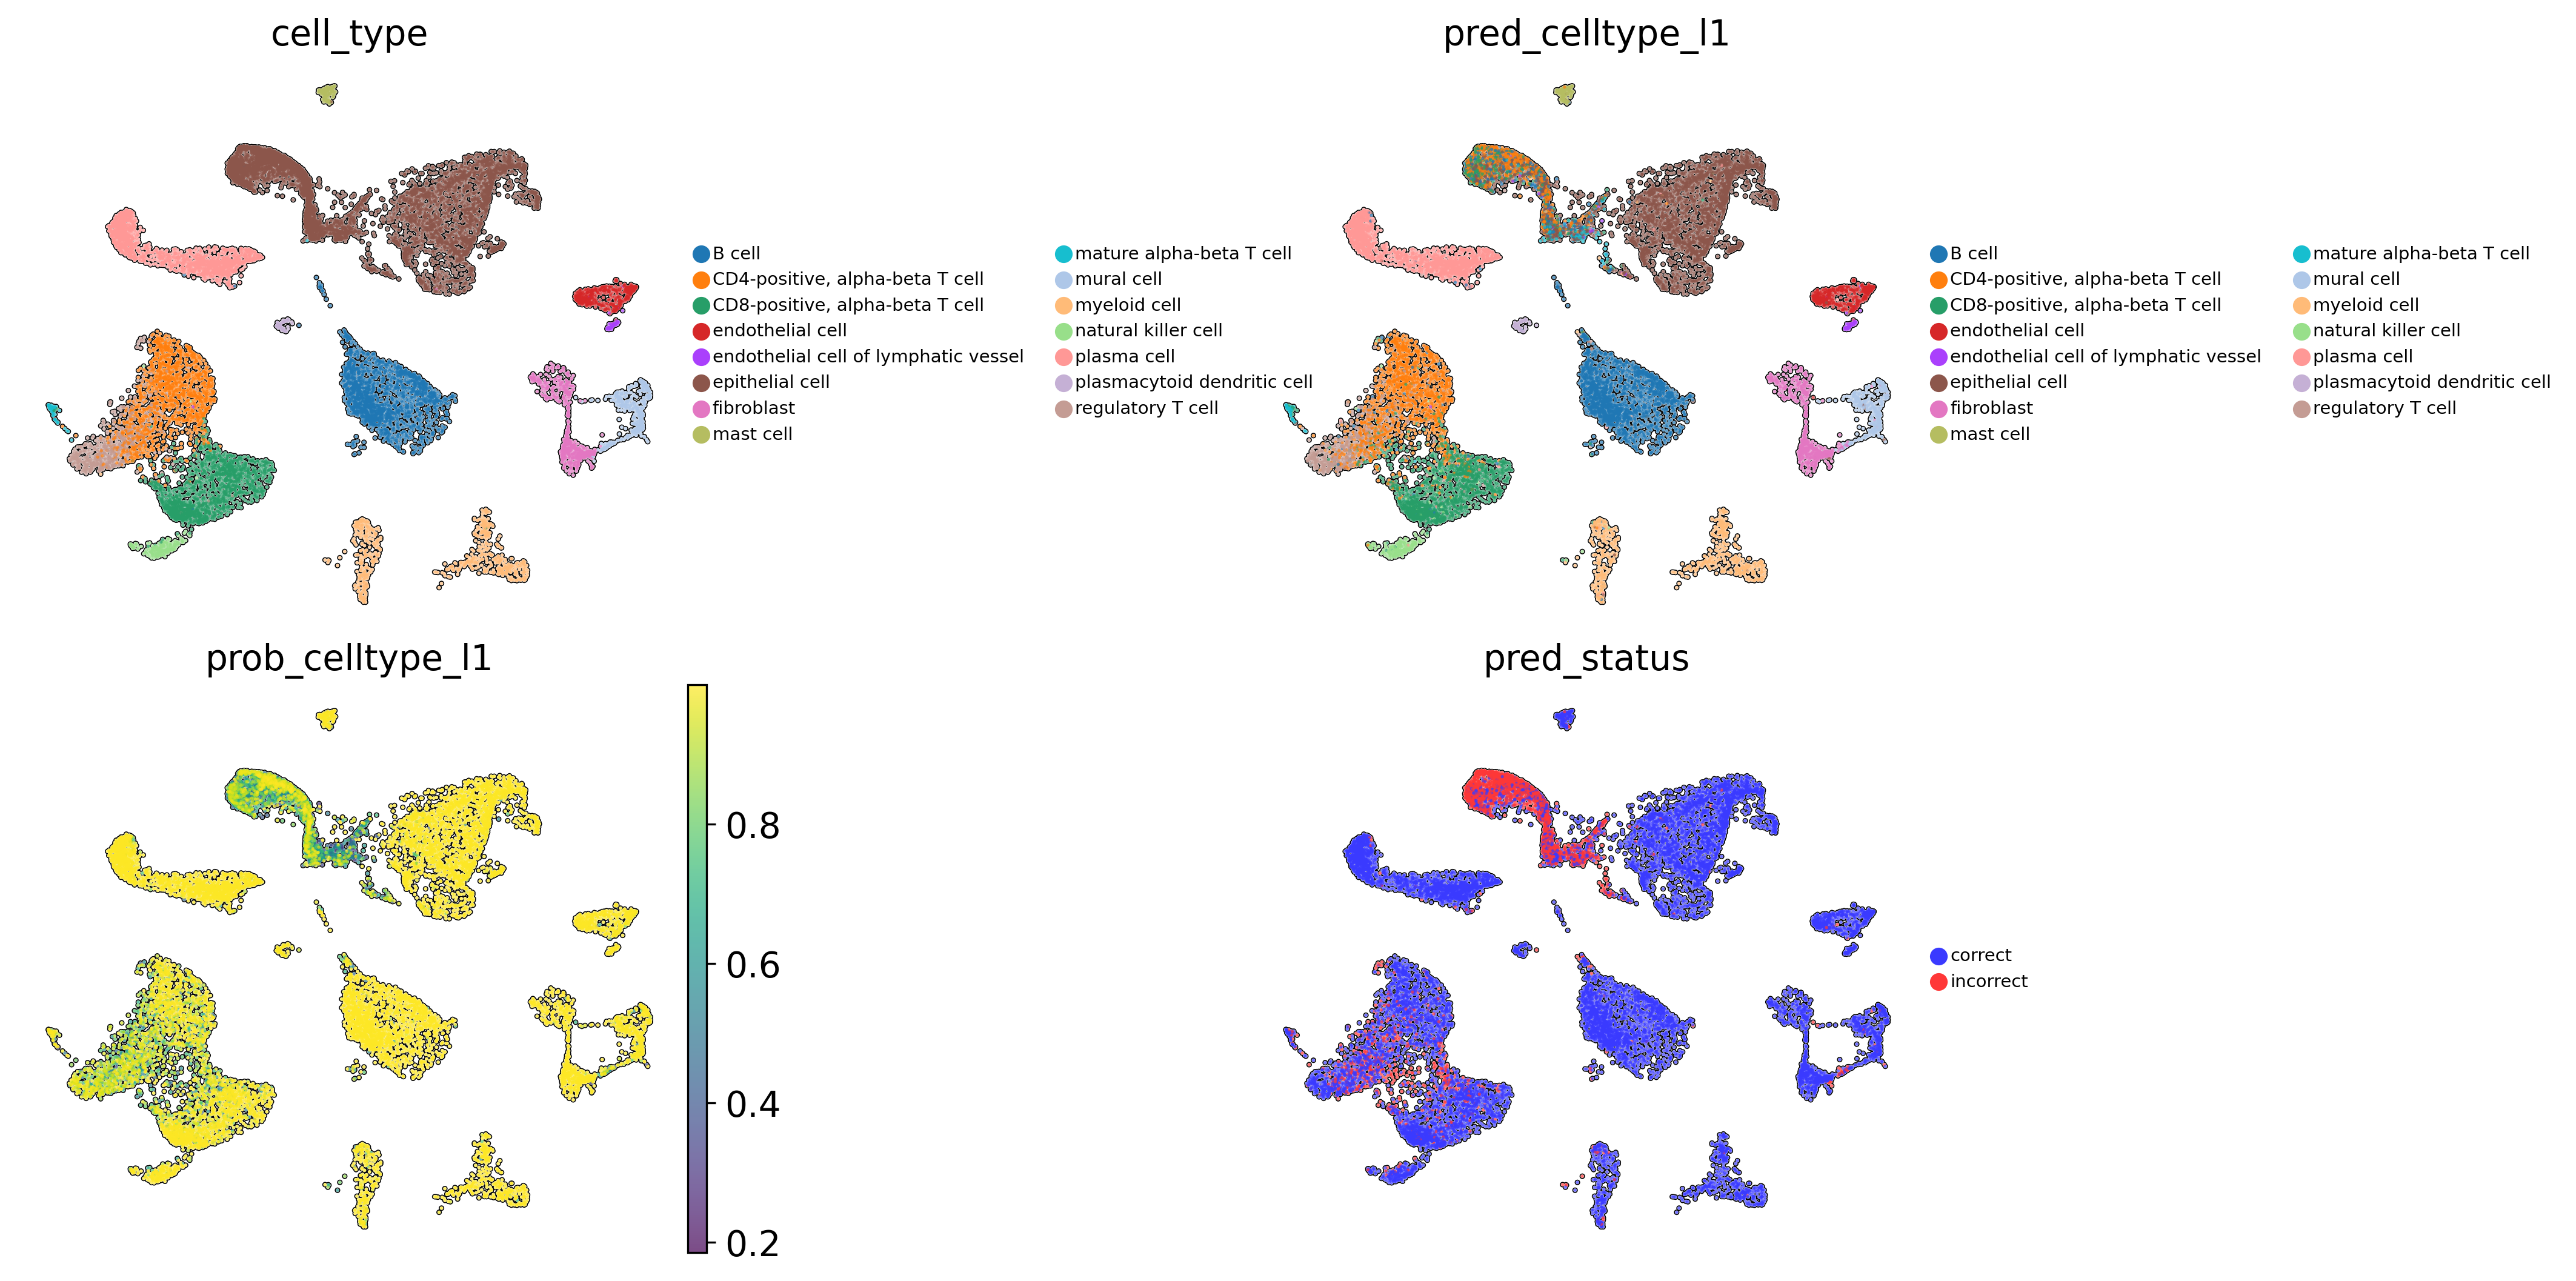

In [26]:
# Visualise predicted cell types levels, prediction probabilities and prediction status
sc.pl.embedding(adata_test, 
                color=[
                    'cell_type',
                    'pred_celltype_l1',
                    'prob_celltype_l1',
                    'pred_status'
                ],
                basis = 'X_umap',
                frameon = False,
                add_outline = True,
                legend_loc = 'right margin',
                legend_fontsize = 7,
                legend_fontoutline = 1,
                ncols=2,
                wspace = 0.7, 
                hspace = 0.1)

In [40]:
# Compare prediction results
# 'self' row represents untuned model
# 'other' row represents tuned model
df.compare(df_hp_tuned, keep_equal=True, align_axis = 0, result_names=('untuned', 'hp tuned'))

precision recall/sensitivity  \
B cell                               untuned      0.8170               0.98   
                                     hp tuned     0.7263             0.9863   
CD4-positive, alpha-beta T cell      untuned      0.5112             0.8481   
                                     hp tuned     0.4301             0.8616   
CD8-positive, alpha-beta T cell      untuned      0.6327             0.8829   
                                     hp tuned     0.6414             0.8852   
endothelial cell                     untuned      0.7873             0.9803   
                                     hp tuned     0.9934             0.9891   
endothelial cell of lymphatic vessel untuned      0.8475             0.9615   
                                     hp tuned     0.5532                1.0   
epithelial cell                      untuned      0.9907             0.4994   
                                     hp tuned     0.9897             0.5518   
fibroblast                           untuned      0.9379             0.8935   
                                     hp tuned     0.9585             0.9911   
mast cell                            untuned      0.9797             0.9797   
                                     hp tuned     0.9793             0.9595   
mature alpha-beta T cell             untuned      0.0665               0.84   
                                     hp tuned     0.2783             0.8533   
mural cell                           untuned      0.8173             0.9519   
                                     hp tuned     0.9779             0.9108   
myeloid cell                         untuned      0.8784             0.9449   
                                     hp tuned     0.9283             0.9628   
natural killer cell                  untuned      0.5929             0.9731   
                                     hp tuned     0.7616             0.9596   
plasma cell                          untuned      0.9810             0.9937   
                                     hp tuned     0.9881             0.9922   
plasmacytoid dendritic cell          untuned      0.9231               0.96   
                                     hp tuned     0.9608               0.98   
regulatory T cell                    untuned      0.4762             0.7143   
                                     hp tuned     0.6378             0.7187   
macro avg                            untuned      0.7493             0.8936   
                                     hp tuned     0.7870             0.9068   
weighted avg                         untuned      0.8512             0.7479   
                                     hp tuned     0.8553             0.7749   
Accuracy                             untuned      0.7479                      
                                     hp tuned     0.7749                      
Balanced accuracy                    untuned      0.8936                      
                                     hp tuned     0.9068                      

                                              specificity f1-score  \
B cell                               untuned       0.9723   0.8911   
                                     hp tuned      0.9531   0.8366   
CD4-positive, alpha-beta T cell      untuned       0.9248   0.6379   
                                     hp tuned      0.8941   0.5738   
CD8-positive, alpha-beta T cell      untuned       0.9461   0.7371   
                                     hp tuned      0.9479   0.7438   
endothelial cell                     untuned       0.9932   0.8733   
                                     hp tuned      0.9998   0.9912   
endothelial cell of lymphatic vessel untuned       0.9995   0.9009   
                                     hp tuned      0.9977   0.7123   
epithelial cell                      untuned       0.9968   0.6641   
                                     hp tuned       0.996   0.7085   
fibroblast                           untuned       0.99

In [28]:
# Compare prediction results
# 'self' row represents warm start trained model
# 'other' row represents tuned model
df_warm_start.compare(df_hp_tuned, keep_equal=True, align_axis = 0, result_names=('warm start', 'hp tuned'))

precision recall/sensitivity  \
B cell                               self      0.9620             0.9634   
                                     other     0.7263             0.9863   
CD4-positive, alpha-beta T cell      self      0.7871             0.7091   
                                     other     0.4301             0.8616   
CD8-positive, alpha-beta T cell      self      0.7919             0.7755   
                                     other     0.6414             0.8852   
endothelial cell                     self      0.9956             0.9912   
                                     other     0.9934             0.9891   
endothelial cell of lymphatic vessel self      0.6538             0.9808   
                                     other     0.5532                1.0   
epithelial cell                      self      0.9899             0.7571   
                                     other     0.9897             0.5518   
fibroblast                           self      0.8156             0.9882   
                                     other     0.9585             0.9911   
mast cell                            self      0.8182              0.973   
                                     other     0.9793             0.9595   
mature alpha-beta T cell             self      0.0840             0.9733   
                                     other     0.2783             0.8533   
mural cell                           self      0.5175              0.913   
                                     other     0.9779             0.9108   
myeloid cell                         self      0.9038             0.9573   
                                     other     0.9283             0.9628   
natural killer cell                  self      0.5472             0.9103   
                                     other     0.7616             0.9596   
plasma cell                          self      0.9827             0.9786   
                                     other     0.9881             0.9922   
plasmacytoid dendritic cell          self      0.7385               0.96   
                                     other     0.9608               0.98   
regulatory T cell                    self      0.4942             0.8047   
                                     other     0.6378             0.7187   
macro avg                            self      0.7388              0.909   
                                     other     0.7870             0.9068   
weighted avg                         self      0.8982             0.8346   
                                     other     0.8553             0.7749   
Accuracy                             self      0.8346                      
                                     other     0.7749                      
Balanced accuracy                    self      0.9090                      
                                     other     0.9068                      

                                           specificity f1-score  \
B cell                               self       0.9952   0.9627   
                                     other      0.9531   0.8366   
CD4-positive, alpha-beta T cell      self       0.9822   0.7461   
                                     other      0.8941   0.5738   
CD8-positive, alpha-beta T cell      self       0.9786   0.7836   
                                     other      0.9479   0.7438   
endothelial cell                     self       0.9999   0.9934   
                                     other      0.9998   0.9912   
endothelial cell of lymphatic vessel self       0.9985   0.7846   
                                     other      0.9977   0.7123   
epithelial cell                      self       0.9946    0.858   
                                     other       0.996   0.7085   
fibroblast                           self       0.9914   0.8936   
                                     other      0.9984   0.9745   
mast cell                            self       0.9982   0.8889   
       

## Recommendation
We recommend <strong>warm start</strong> training instead of<strong> hyperparameter tuning</strong> if possible. <br>
However, in the absence of an additional training dataset, hyperparameter tuning may help improve model performance.

In [42]:
pip list

Package                       Version
----------------------------- --------------
absl-py                       2.1.0
accessible-pygments           0.0.5
aiohappyeyeballs              2.4.2
aiohttp                       3.10.8
aiosignal                     1.3.1
alabaster                     0.7.16
alembic                       1.13.3
anndata                       0.10.8
anyio                         4.6.0
argon2-cffi                   23.1.0
argon2-cffi-bindings          21.2.0
array_api_compat              1.8
arrow                         1.3.0
asttokens                     2.4.1
async-lru                     2.0.4
async-timeout                 4.0.3
attrs                         24.2.0
babel                         2.16.0
beautifulsoup4                4.12.3
bleach                        6.1.0
certifi                       2024.8.30
cffi                          1.17.1
charset-normalizer            3.3.2
chex                          0.1.86
colorlog                      6.8.2
comm